# Imports

In [16]:
# Python imports
import sys,os
import numpy as np
import pylab as py
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.special as spec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import json
# FutureWarning hack
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    # Own .py file imports
    import mceg
    from tools import load, save, checkdir, lprint

# Auxiliary definitions

In [28]:
with open( 'gen_parms.json' ) as json_file:
    inparms = json.load(json_file)

In [29]:
json_formatted_str = json.dumps(inparms, indent=2)

In [30]:
print(json_formatted_str)

{
  "generator": {
    "_comment0": "Number of events to generate.",
    "nevents": 1000000
  },
  "bootstrap": {
    "_comment0": "Number of bootstrap random samples",
    "rand": 1000,
    "_comment1": "Sample size of a single bootstrap generation",
    "bootsamp": 100000
  },
  "histograms": {
    "_comment0": "Number of bins in the 1D histos",
    "bins": 100
  }
}


In [20]:
nevents = inparms['generator']['nevents']
rand = inparms['bootstrap']['rand']
bootsamp = inparms['bootstrap']['bootsamp']
bins = inparms['histograms']['bins']

In [21]:
# Constants
Mp = 0.93827
Mpi = 0.1395

In [22]:
# Auxiliary function for histogram generation
def get_xy_steps(xbins,yvalues):
    X,Y=[],[]
    for i in range(len(xbins)-1):
        x1=xbins[i]
        x2=xbins[i+1]
        y=yvalues[i]            
        X.append(x1)
        Y.append(y)
        X.append(x2)
        Y.append(y)
    return np.array(X),np.array(Y) 

In [23]:
# Auxiliary functions for manipulation of arrays of 4-vectors
def dot(A,B):
    return A[0]*B[0] - A[1]*B[1] - A[2]*B[2] - A[3]*B[3]

def add(A,B):
    ApB={}
    ApB[0]=A[0]+B[0] 
    ApB[1]=A[1]+B[1] 
    ApB[2]=A[2]+B[2] 
    ApB[3]=A[3]+B[3] 
    return ApB

def sub(A,B):
    AmB={}
    AmB[0]=A[0]-B[0] 
    AmB[1]=A[1]-B[1] 
    AmB[2]=A[2]-B[2] 
    AmB[3]=A[3]-B[3] 
    return AmB

# Generating and storing GAN events

In [24]:
# This generates lab-frame GAN events and stores the information needed from them:
# 4-momenta and invariants
def gen_lab(nsamples=1000000):
    evts=mceg.gen_samples(nsamples)
    samples=evts.T
    MX2=samples[0] # squared missing mass of the pi-
    N = len(MX2)
    nu=samples[1] # photon energy in the lab frame
    rec={} # recoil-proton 4-momentum
    rec[0]=samples[11]
    rec[1]=samples[2]
    rec[2]=samples[5]
    rec[3]=samples[8]
    pip={}  # pi+ 4-momentum
    pip[0]=samples[12]
    pip[1]=samples[3]
    pip[2]=samples[6]
    pip[3]=samples[9]
    pim={}  # missing pi- 4-momentum
    pim[0]=samples[13]
    pim[1]=samples[4]
    pim[2]=samples[7]
    pim[3]=samples[10]
    beam={}  # photon 4-momentum
    beam[0]=nu
    beam[1]=np.zeros(N)
    beam[2]=np.zeros(N)
    beam[3]=nu
    targ={}  # target 4-momentum
    targ[0]=Mp*np.ones(N)
    targ[1]=np.zeros(N)
    targ[2]=np.zeros(N)
    targ[3]=np.zeros(N)
    
    Mpipi=np.sqrt(dot(add(pim,pip),add(pim,pip)))  # pi+pi- invariant mass
    s=dot(add(targ,beam),add(targ,beam))  # photon-target invariant mass squared
    sppip=dot(add(rec,pip),add(rec,pip))  # recoil-pi+ invariant mass squared
    sppim=dot(add(rec,pim),add(rec,pim))  # recoil-pi- invariant mass squared
    t=dot(sub(targ,rec),sub(targ,rec))  # Mandelstam t (target - recoil)^2
    tpip=dot(sub(beam,pip),sub(beam,pip))  # Mandelstam t for (photon - pi+)^2
    tpim=dot(sub(beam,pim),sub(beam,pim))  # Mandelstam t for (photon - pi-)^2
    ganevents=beam,targ,pip,pim,rec,MX2,nu,Mpipi,s,sppip,sppim,t,tpip,tpim
    checkdir('./evtsnpy')  
    np.save('./evtsnpy/GAN_evts-lab.npy', ganevents)
    return ganevents

# Plotter

In [25]:
# This creates and stores numpy data for histograms: here we show the example for a pi+pi- invariant mass histogram
def gen_hist(bins = 100,rand=100,bootsamp=100):
    ganevents=np.load('./evtsnpy/GAN_evts-lab.npy',allow_pickle=True)
    beam,targ,pip,pim,rec,MX2,nu,Mpipi,s,sppip,sppim,t,tpip,tpim=ganevents
    # In the following we keep only those data that are within some choice of cuts
    I=[i for i in range(MX2.size) if (3.8>nu[i]>3.0 and abs(MX2[i]-0.019)<0.06)]
    Mpipi=Mpipi[I]
    cnt=len(Mpipi)
    print(cnt)
    # The range of Mpipi to be plotted
    Rpipi=(0.4,1.4)
    Y=[]
    '''
    For error bands, we bootstrap n=rand times over samples of subsets of size=bootsamp.
    bootsamp has to be chosen such as to be smaller than the full GAN data size=cnt (after cuts).
    To make sure of this, we print out cnt above.
    '''
    for k in range(rand):    
        subset=np.random.choice(np.arange(cnt),bootsamp,replace=True)
        Mpipisubs=Mpipi[subset]
        H,E=np.histogram(Mpipisubs,range=Rpipi,bins=bins)
        x,y=get_xy_steps(E,H/bootsamp)
        Y.append(y)
    avy=np.mean(Y,axis=0)
    dy=np.std(Y,axis=0)
    data={}
    data['X']=x
    data['Y']=avy
    data['dY']=dy #--statistical uncertainties
    data['Ymin']=avy-dy
    data['Ymax']=avy+dy
    checkdir('data')
    save(data,'data/hist-gan-lab.po')
    return

# Plotter for the above example histogram data from the GAN generator
def gen_hist_plots():
    gan1=load('data/hist-gan-lab.po')
    
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*5,nrows*4))

    ########################
    ax=py.subplot(nrows,ncols,1)
    hg1 =ax.fill_between(gan1['X'],gan1['Ymin'],gan1['Ymax'],color='b',alpha=0.5)
    lg1,=ax.plot(gan1['X'],gan1['Y'],'b-')
    ax.legend([(hg1,lg1)],[r'lab-frame GAN'])
    ax.set_xlabel(r'$M_{\pi\pi}$',size=20)
    ax.set_ylabel(r'Normalized events',size=20)

    ########################
    checkdir('gallery')
    py.tight_layout()
    py.savefig('gallery/Mpipi_lab-GAN.pdf')
    return

# Runs all needed functions for example case

In [31]:
# Generates a nsamples-sized batch of GAN data
ganevents = gen_lab(nsamples=nevents)

740971


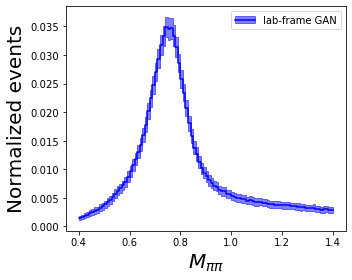

In [32]:
# Generates histogram data with nbins=bins,
# bootstrapping n=rand times over random samples of size=bootsamp.
# As a test, the sizes of the full data samples are being printed out,
# in order to make sure that bootsamp os not too large.
gen_hist(bins=bins,rand=rand,bootsamp=bootsamp)
gen_hist_plots()

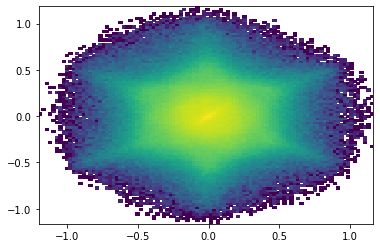

In [33]:
a, b, c, i = plt.hist2d(ganevents[3][1],ganevents[3][2], bins=100, norm=mcolors.LogNorm())

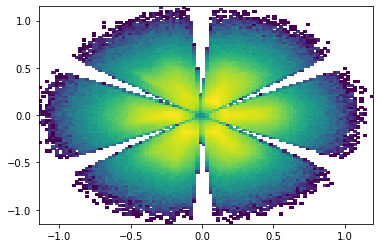

In [34]:
a, b, c, i = plt.hist2d(ganevents[2][1],ganevents[2][2], bins=100, norm=mcolors.LogNorm())

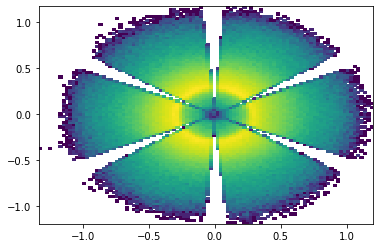

In [35]:
a, b, c, i = plt.hist2d(ganevents[4][1],ganevents[4][2], bins=100, norm=mcolors.LogNorm())